# SemEval 2016 Slot1 Task: GloVe Average with Gold (target) Attention


This notebook is to make a baseline for slot1, aspect category detection. We use glove to generate sentence vector. 

Because we want to augment the embedding wegiht of target word to evaluate whether or not the attention is useful. 

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

In [2]:
train_path = Path.cwd().parent.joinpath('datasets/semeval-2016/train.csv')
test_path = Path.cwd().parent.joinpath('datasets/semeval-2016/test.csv')

In [3]:
# Read data
data_train = pd.read_csv(train_path)
data_test = pd.read_csv(test_path)

In [4]:
def df2data(df):
    """Read data and labels from dataframe
    Input:
        df: three columns, ['Sentence #', 'Tag', 'Word']
    Output:
        data: datasize * ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']
        label: datasize * ['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']
    """
    agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),
                                                 s["Tag"].values.tolist())]
    grouped = df.groupby("Sentence #").apply(agg_func)
    data = [[w[0] for w in s] for s in grouped]
    label = [[w[1] for w in s] for s in grouped]  
    
    return data, label

In [5]:
import xml.etree.ElementTree as ET
from collections import namedtuple
from collections import Counter


def read_targets(file_path):
    root = ET.parse(file_path)
    sentences = []
    class_targets = {}
    for review in root.findall("./Review"):
        for sentence in review.findall("./sentences/sentence"):
            targets = []
            for opinion in sentence.findall("./Opinions/Opinion"):
                target = opinion.attrib["target"]
                _class = opinion.attrib["category"]
                if target != "NULL":
                    targets.append(target)
                    if _class not in class_targets:
                        class_targets[_class] = Counter()
                    class_targets[_class][target] += 1
                
            sentences.append(targets)
                
    return sentences, class_targets

In [6]:
# load target words from npy
train_target_path = '../datasets/raw-semeval-2016/train.xml'
test_target_path = '../datasets/raw-semeval-2016/test.xml'

train_targets, train_class_targets = read_targets(train_target_path)
test_targets, test_class_targets = read_targets(test_target_path)
print(len(train_targets))
print(len(test_targets))
print(train_targets[:10])
print(train_class_targets["FOOD#QUALITY"].most_common()[:3])

2000
676
[['place'], ['staff'], [], ['food', 'portions'], [], ['place'], ['food'], ['Saul'], ['foie gras terrine with figs', 'duck confit'], ['wine list', 'wine list']]
[('food', 188), ('pizza', 20), ('sushi', 19)]


In [7]:
x_train_words, _ = df2data(data_train)
x_test_words, _ = df2data(data_test)

### embedding

In [8]:
def load_glove(file):
    """Loads GloVe vectors in numpy array.
    Args:
        file (str): a path to a glove file.
    Return:
        dict: a dict of numpy arrays.
    """
    model = {}
    with open(file, encoding="utf-8") as f:
        for line in f:
            line = line.split(' ')
            word = line[0]
            vector = np.array([float(val) for val in line[1:]])
            model[word] = vector

    return model

In [9]:
EMBEDDING_PATH = '../embedding_weights/glove.6B/glove.6B.200d.txt'

In [10]:
embeddings = load_glove(EMBEDDING_PATH)

Sum all to `word2vector_weighted` function, augment the weight if the word is target word

In [11]:
def word2vector_weighted(x_words, targets, weight=2, vector_size=200, verbose=False):

    sentence_vectors = []
    no_word_match = 0

    for sent, _targets in zip(x_words, targets):
        vector = []

        for word in sent:
            if embeddings.get(word) is None:
                continue

            e = embeddings[word]
            # simple method to match multiple target
            if sum([1 if word in t else 0 for t in _targets]) > 0:
                e = e * weight
            vector.append(e)

        if len(vector) > 0:
            sentence_vectors.append(np.mean(vector, axis=0))
        else:
            sentence_vectors.append(np.array([0] * vector_size))
            no_word_match += 1

    if verbose and no_word_match > 0:
        print("{} sentences does not match any pretrained vector.".format(no_word_match))

    return np.array(sentence_vectors)

In [12]:
x_train = word2vector_weighted(x_train_words, train_targets, verbose=True)
x_test = word2vector_weighted(x_test_words, test_targets, verbose=True)

1 sentences does not match any pretrained vector.


In [13]:
print(x_train.shape)
print(x_test.shape)

(2000, 200)
(676, 200)


### label 

this is a multicalss classification

In [14]:
train_path = Path.cwd().parent.joinpath('datasets/semeval-2016/slot1/train_label_df.csv')
test_path = Path.cwd().parent.joinpath('datasets/semeval-2016/slot1/test_label_df.csv')

In [15]:
y_train_df = pd.read_csv(train_path)
y_test_df = pd.read_csv(test_path)

In [16]:
y_train_df.head(3)

,AMBIENCE#GENERAL,DRINKS#PRICES,DRINKS#QUALITY,DRINKS#STYLE_OPTIONS,FOOD#PRICES,FOOD#QUALITY,FOOD#STYLE_OPTIONS,LOCATION#GENERAL,RESTAURANT#GENERAL,RESTAURANT#MISCELLANEOUS,RESTAURANT#PRICES,SERVICE#GENERAL
0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,1


# model construct

In [17]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

%matplotlib inline

# learning curve function
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

def plot_learning_curve(
        estimator, title, X, y, ylim=None, cv=None,
        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5), verbose=0):

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, verbose=verbose)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

[learning_curve] Training set sizes: [ 160  520  880 1240 1600]
[CV]  ................................................................
[CV] ................................... , score=0.3475, total=   0.0s
[CV]  ................................................................
[CV] ................................... , score=0.4125, total=   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV] ................................... , score=0.4275, total=   0.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s


[CV] ................................... , score=0.4675, total=   0.2s
[CV]  ................................................................
[CV] ................................... , score=0.4725, total=   0.3s
[CV]  ................................................................
[CV] .................................... , score=0.315, total=   0.0s
[CV]  ................................................................
[CV] ..................................... , score=0.41, total=   0.0s
[CV]  ................................................................
[CV] ................................... , score=0.4225, total=   0.1s
[CV]  ................................................................
[CV] ................................... , score=0.4275, total=   0.2s
[CV]  ................................................................
[CV] .................................... , score=0.435, total=   0.3s
[CV]  ................................................................
[CV] .

c:\users\tie301837\env\continuum\miniconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))


[CV] ..................................... , score=0.42, total=   0.1s
[CV]  ................................................................
[CV] ..................................... , score=0.43, total=   0.2s
[CV]  ................................................................
[CV] ................................... , score=0.4375, total=   0.3s
[CV]  ................................................................
[CV] .................................... , score=0.325, total=   0.0s
[CV]  ................................................................
[CV] .................................... , score=0.425, total=   0.0s
[CV]  ................................................................
[CV] ................................... , score=0.4175, total=   0.1s
[CV]  ................................................................
[CV] .................................... , score=0.435, total=   0.2s
[CV]  ................................................................
[CV] .

c:\users\tie301837\env\continuum\miniconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 7 is present in all training examples.
  str(classes[c]))


[CV] .................................... , score=0.405, total=   0.1s
[CV]  ................................................................
[CV] ................................... , score=0.4125, total=   0.2s
[CV]  ................................................................
[CV] ................................... , score=0.4175, total=   0.3s


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    5.3s finished


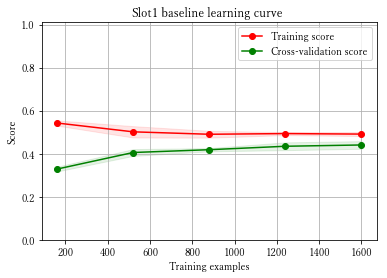

In [18]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ShuffleSplit


cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
ovr = OneVsRestClassifier(LogisticRegression())

plot_learning_curve(ovr, "Slot1 baseline learning curve ",
                    x_train, y_train_df, ylim=(0.0, 1.01), cv=cv, n_jobs=1, verbose=4)

plt.show()

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score


def calc_score(x_train, y_train, x_test, y_test):
    ovr = OneVsRestClassifier(LogisticRegression())
    ovr.fit(x_train, y_train)

    predicted = ovr.predict(x_test)
    score = f1_score(y_test, predicted, average="micro")
    return score

In [20]:
for w in [1, 1.5, 2, 2.5, 3]:
    x_train = word2vector_weighted(x_train_words, train_targets, weight=w)
    x_test = word2vector_weighted(x_test_words, test_targets, weight=w)
    s = calc_score(x_train, y_train_df, x_test, y_test_df)
    print("f1 score is {} when weight is {}".format(s, w))

f1 score is 0.5942386831275719 when weight is 1
f1 score is 0.6142625607779579 when weight is 1.5
f1 score is 0.6318327974276527 when weight is 2
f1 score is 0.6337579617834395 when weight is 2.5
f1 score is 0.632831086439334 when weight is 3
